In [1]:
import os

import pymongo
from dotenv import load_dotenv
from pymongo import MongoClient
from tqdm import tqdm

load_dotenv("../env")
client = MongoClient(os.environ.get("MONGO_DB_CONNECTION"))
db = client.get_database("prismai")

In [2]:
# collected_items = db.get_collection("collected_items")
collection_transition_scores = db.get_collection("test_swt")

In [3]:
# arxiv_papers = {doc["_id"] for doc in collected_items.find({"domain": "arxiv_papers"}, projection=["_id"])}
# ids = (doc["refs"]["_ref_id"]["$id"] for doc in transition_scores.find(projection={"refs._ref_id.$id"}))#
# arxiv_ids = {_id for _id in ids if _id in arxiv_papers}

# print(len(arxiv_ids))

# for _id in tqdm(arxiv_ids):
#     collected_items.delete_one({"_id": _id})
#     transition_scores.delete_many({"refs._ref_id.$id": _id})

In [4]:
from simple_dataset import Dataset
from transition_scores.data import FeaturesDict, TransitionScores

dataset = Dataset(
    FeaturesDict.new(**document) for document in collection_transition_scores.find()
)
len(dataset)

32

In [5]:
dataset.apply(TransitionScores.merge, "transition_scores")
type(dataset[0]["transition_scores"])

transition_scores.data.TransitionScores

In [6]:
from itertools import islice

import numpy as np
from matplotlib import pyplot as plt

In [7]:
def viz2d(features: np.array):
    fig = plt.imshow(features, cmap="gray")
    fig.axes.set_axis_off()
    return fig

In [64]:
def fixed_2d_features(
    transition_scores: TransitionScores,
    w: int,
    h: int,
    skip: int = 1,
    no_overlap: bool = False,
    take_first: bool = False,
    sort_slices: bool = True,
):
    if no_overlap:
        raise NotImplementedError("no_overlap not implemented")

    size = len(transition_scores) - skip - w
    if size < w:
        raise ValueError(
            f"Sequence is too short: ({len(transition_scores)} - {skip} - {w}) < {w}"
        )

    if take_first:
        offsets = np.arange(skip, size, w)[:h]
        if not sort_slices:
            offsets = np.random.permutation(offsets)
    else:
        offsets = np.random.choice(size, h, replace=False) + skip
        if sort_slices:
            offsets = np.sort(offsets)

    features = np.zeros((h, w))
    for i, offset in enumerate(offsets):
        features[i] = transition_scores.target_probs[offset : offset + w]

    return features

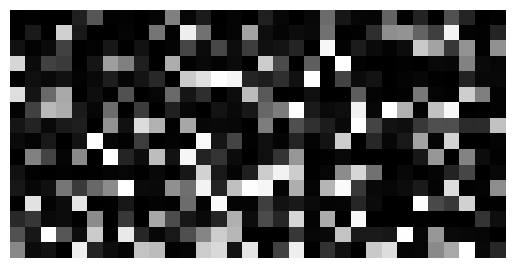

In [65]:
features = fixed_2d_features(dataset[3]["transition_scores"], 32, 16, take_first=True)
viz2d(features)
plt.show()

In [66]:
def viz3d(features: np.array):
    h, w, d = features.shape
    d = int(np.ceil(np.sqrt(d)))
    fig, axes = plt.subplots(d, d, figsize=(5, h / w * 5))
    for i, ax in enumerate(axes.flat):
        if i < features.shape[-1]:
            ax.imshow(features[..., i], cmap="gray")
        ax.set_axis_off()
    return fig

In [107]:
from warnings import warn


def fixed_3d_features(
    transition_scores: TransitionScores,
    w: int,
    h: int,
    d: int,
    skip: int = 1,
    take_first: bool = False,
    no_overlap: bool = False,
    remove_target: bool = False,
    sort_slices: bool = True,
):
    if no_overlap:
        raise NotImplementedError("no_overlap not implemented")

    size = len(transition_scores) - skip - w
    if size < w:
        raise ValueError(
            f"Sequence is too short: ({len(transition_scores)} - {skip} - {w}) < {w}"
        )
    if size < w * h:
        warn(
            f"Sequence very short, will produce overlapping offsets: ({len(transition_scores)} - {skip} - {w}) = {size} < {w * h}"
        )
    ts = transition_scores[skip:]

    if take_first:
        offsets = np.arange(0, size, w)[:h]
        if not sort_slices:
            offsets = np.random.permutation(offsets)
    else:
        offsets = np.random.choice(size, h, replace=False) + skip
        if sort_slices:
            offsets = np.sort(offsets)

    top_k_probs = [
        list(
            islice(
                (
                    prob
                    for top_id, prob in zip(top_ids, top_probs)
                    if remove_target or top_id != tgt_id
                ),
                d - 1,
            )
        )
        for tgt_id, top_ids, top_probs in zip(
            ts.target_ids,
            ts.top_k_indices,
            ts.top_k_probs,
        )
    ]
    top_k_probs = np.array(top_k_probs)

    features = np.empty((h, w, d))
    for i, offset in enumerate(offsets):
        features[i, :, 0] = ts.target_probs[offset : offset + w]
        features[i, :, 1:] = top_k_probs[offset : offset + w][:, ::-1]
    return features


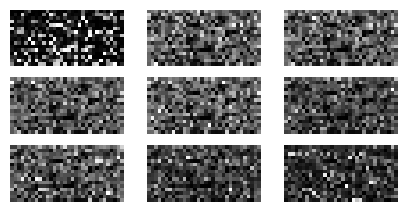

In [108]:
features = fixed_3d_features(dataset[3]["transition_scores"], 32, 16, 9, take_first=True)
viz3d(features)
plt.show()

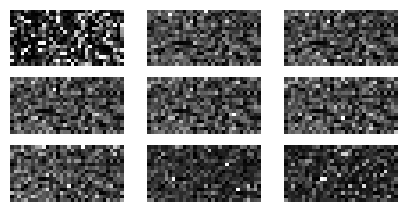

In [109]:
features = fixed_3d_features(dataset[-1]["transition_scores"], 32, 16, 9, take_first=True)
viz3d(features)
plt.show()

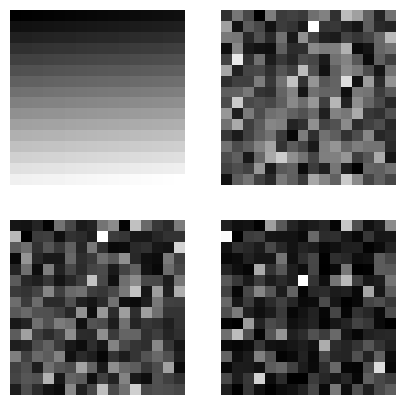

In [110]:
seq_len = 1024
vocab_size = 128
top_k = 10
ts = TransitionScores(
    list(range(seq_len)),
    (np.arange(seq_len)/seq_len).tolist(),
    [np.random.choice(vocab_size, top_k, replace=False) for _ in range(seq_len)],
    [list(sorted(np.random.rand(top_k).tolist())) for _ in range(seq_len)],
)
features = fixed_3d_features(ts, 16, 16, 4, take_first=True)
viz3d(features)
plt.show()